# 0.0 Imports

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import warnings
import re

import umap.umap_ as umap

from IPython.display import HTML
from matplotlib import pyplot as plt

from pandas_profiling import ProfileReport

from sklearn            import cluster       as c
from sklearn            import metrics       as m
from sklearn            import preprocessing as pp
from sklearn            import decomposition as dd
from sklearn.manifold   import TSNE
from sklearn            import manifold      as mn
from sklearn            import ensemble      as en
from sklearn            import mixture       as mx

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

warnings.simplefilter("ignore")

C:\Users\kaka\anaconda3\envs\insiders\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Load DataSet

In [3]:
# load data
df_raw = pd.read_csv( 'C:/Users/kaka/Projetos_DS/insiders_clustering/data/raw/Ecommerce.csv', encoding='unicode_escape' )

# 1.0 Descrição dos Dados

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data dimensions

In [6]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


## 1.3 Data Types

In [7]:
 df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [9]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [10]:
 # create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

In [11]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change DTypes

In [12]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], infer_datetime_format=True ).dt.date
# customer id
df1['customer_id'] = df1['customer_id'].astype( 'int64' )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,United Kingdom,17850


## 1.7 Descriptive Statistics

In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributs

In [14]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.7.1.1 Numerical Attributs Investigating

1. Quantity negativa ( pode ser devolução )

2. Preço unitário igual a zero ( pode ser promoção? )

### 1.7.1 Categorical Attributs

In [15]:
# problema: Temos invoice com letras e numeros
#df1['invoice_no'].astype( int )

# identficacao: 
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


### Stock Code

In [16]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Acão:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

### Country

In [17]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [18]:
df1['country'].value_counts( normalize=True ).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [19]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count().reset_index().sort_values( 'customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0 Data Filtering

In [20]:
df2 = df1.copy()

In [21]:
# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop( columns='description', axis=1 )

# map -  
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# 3.0 Feature Engineering

In [22]:
df3 = df2.copy()

## 3.1 Feature Selection

In [23]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

In [24]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

In [25]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

In [26]:
# QUantity of purchased
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename( columns={'invoice_no': 'qtde_invoices'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

In [27]:
# Quantity total of items purchased
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qtde_items'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

In [28]:
 # Quantity of products purchased
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

In [29]:
 # Avg Ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

In [30]:
# Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id','invoice_date' ], ascending=[False, False] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['previous_date'] - x['invoice_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

In [31]:
#Frequency Purchase

df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

In [32]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

In [33]:
# Basket Size - Quantidade de Items por Cesta ( Quantity )
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

In [34]:
# Unique Basket Size - Quantidade de produtos distintos por compra

df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [35]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,17.000000,40.0,50.970588,0.617647
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.028302,35.0,154.444444,11.666667
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.040323,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.073171,22.0,26.666667,0.333333


# 4.0 EDA

In [36]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1 Univariate Analysis

**Metricas para olharmos**

1. Clusters Coesos - Separados
2. Métricas:

      - Min, Máximo, Range ( Dispersão )
      - Média e MedianaDesvio Padrão e Variância.
      - Coeficiente de Variação ( CV )
      - Distribuição

**Investigar/Remover**

1. Gross Revenue

In [37]:
#profile = ProfileReport( df4 )
#profile.to_file( 'output_v3.html' )

### 4.1.1. Gross Revenue

In [38]:
df4.sort_values( 'gross_revenue', ascending=False ).head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.203390,288.0,2733.944444,9.708333
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,14.680000,0.163043,0.0,1068.733333,2.500000
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,12.821429,0.127778,952.0,1521.586957,2.695652
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,2.601399,0.533512,3332.0,403.331658,8.974874
1150,12415,124564.53,24.0,20.0,77373.0,713.0,174.704811,20.866667,0.063694,427.0,3868.650000,22.150000


In [39]:
df4[df4['gross_revenue'] == 279138.02].head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.20339,288.0,2733.944444,9.708333


In [40]:
df3[df3['customer_id'] == 14646].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2010-12-20,0.29,Netherlands,14646
37953,539491,21986,12,2010-12-20,0.29,Netherlands,14646
37954,539491,22720,2,2010-12-20,4.95,Netherlands,14646
37955,539491,21931,1,2010-12-20,1.95,Netherlands,14646
37956,539491,22613,2,2010-12-20,0.85,Netherlands,14646


### 4.1.2. Qtd Items

In [41]:
df4[df4['qtde_items'] == 196844].head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.20339,288.0,2733.944444,9.708333


In [38]:
df3[df3['customer_id'] == 16446].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


### 4.1.3. Qtd Products

In [43]:
df4[df4['qtde_products'] == 7838].head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
68,17841,40967.72,1.0,124.0,23053.0,7838.0,5.226808,3.321429,0.33244,203.0,185.91129,10.66129


In [55]:
df3[df3['customer_id'] == 17841].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
1441,C536543,22632,-1,2010-12-01,2.10,United Kingdom,17841
1442,C536543,22355,-2,2010-12-01,0.85,United Kingdom,17841
2037,536557,21495,25,2010-12-01,0.42,United Kingdom,17841
2038,536557,46000R,2,2010-12-01,1.45,United Kingdom,17841
2039,536557,46000S,1,2010-12-01,1.45,United Kingdom,17841


### 4.1.4. Avg Ticket

In [47]:
df4[df4['avg_ticket'] == 4453.43]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1262,15749,44534.3,235.0,3.0,18028.0,10.0,4453.43,97.0,0.030612,9014.0,6009.333333,1.666667


In [57]:
df3[df3['customer_id'] == 15749	].head(20)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
52709,540815,85123A,1930,2011-01-11,2.55,United Kingdom,15749
52710,540815,21175,2000,2011-01-11,1.85,United Kingdom,15749
52711,540815,21108,3114,2011-01-11,2.10,United Kingdom,15749
52771,540818,47556B,1300,2011-01-11,2.55,United Kingdom,15749
52772,540818,48185,670,2011-01-11,6.75,United Kingdom,15749
160141,C550456,48185,-670,2011-04-18,6.75,United Kingdom,15749
160142,C550456,47566B,-1300,2011-04-18,2.55,United Kingdom,15749
160143,C550456,85123A,-1930,2011-04-18,2.55,United Kingdom,15749
160144,C550456,21175,-2000,2011-04-18,1.85,United Kingdom,15749
160145,C550456,21108,-3114,2011-04-18,2.10,United Kingdom,15749


### 4.1.5. Frequency

In [51]:
df4[df4['frequency'] == 17]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.5,17.0,40.0,50.970588,0.617647


In [53]:
df3[df3['customer_id'] == 17850].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2010-12-01,2.55,United Kingdom,17850
1,536365,71053,6,2010-12-01,3.39,United Kingdom,17850
2,536365,84406B,8,2010-12-01,2.75,United Kingdom,17850
3,536365,84029G,6,2010-12-01,3.39,United Kingdom,17850
4,536365,84029E,6,2010-12-01,3.39,United Kingdom,17850


### 4.1.6. Avg Basket Size

In [59]:
df4[df4['avg_basket_size'] == 6009.33]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


In [61]:
df4.sort_values( 'avg_basket_size', ascending=False ).head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1262,15749,44534.30,235.0,3.0,18028.0,10.0,4453.430000,97.000000,0.030612,9014.0,6009.333333,1.666667
3278,12590,9341.26,211.0,1.0,4282.0,67.0,139.421791,21.000000,1.000000,4.0,4282.000000,67.000000
1820,18087,3202.92,290.0,1.0,3906.0,1.0,3202.920000,78.500000,1.000000,336.0,3906.000000,1.000000
1150,12415,124564.53,24.0,20.0,77373.0,713.0,174.704811,20.866667,0.063694,427.0,3868.650000,22.150000
1027,13027,6912.00,113.0,6.0,17280.0,26.0,265.846154,48.200000,0.024793,0.0,2880.000000,1.000000


In [63]:
df3[df3['customer_id'] == 15749].head(20)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
52709,540815,85123A,1930,2011-01-11,2.55,United Kingdom,15749
52710,540815,21175,2000,2011-01-11,1.85,United Kingdom,15749
52711,540815,21108,3114,2011-01-11,2.10,United Kingdom,15749
52771,540818,47556B,1300,2011-01-11,2.55,United Kingdom,15749
52772,540818,48185,670,2011-01-11,6.75,United Kingdom,15749
160141,C550456,48185,-670,2011-04-18,6.75,United Kingdom,15749
160142,C550456,47566B,-1300,2011-04-18,2.55,United Kingdom,15749
160143,C550456,85123A,-1930,2011-04-18,2.55,United Kingdom,15749
160144,C550456,21175,-2000,2011-04-18,1.85,United Kingdom,15749
160145,C550456,21108,-3114,2011-04-18,2.10,United Kingdom,15749


## 4.2 Bivariate Analysis

In [64]:
cols = ['customer_id']
df42 = df4.drop( cols, axis=1 )

<Figure size 1800x864 with 0 Axes>

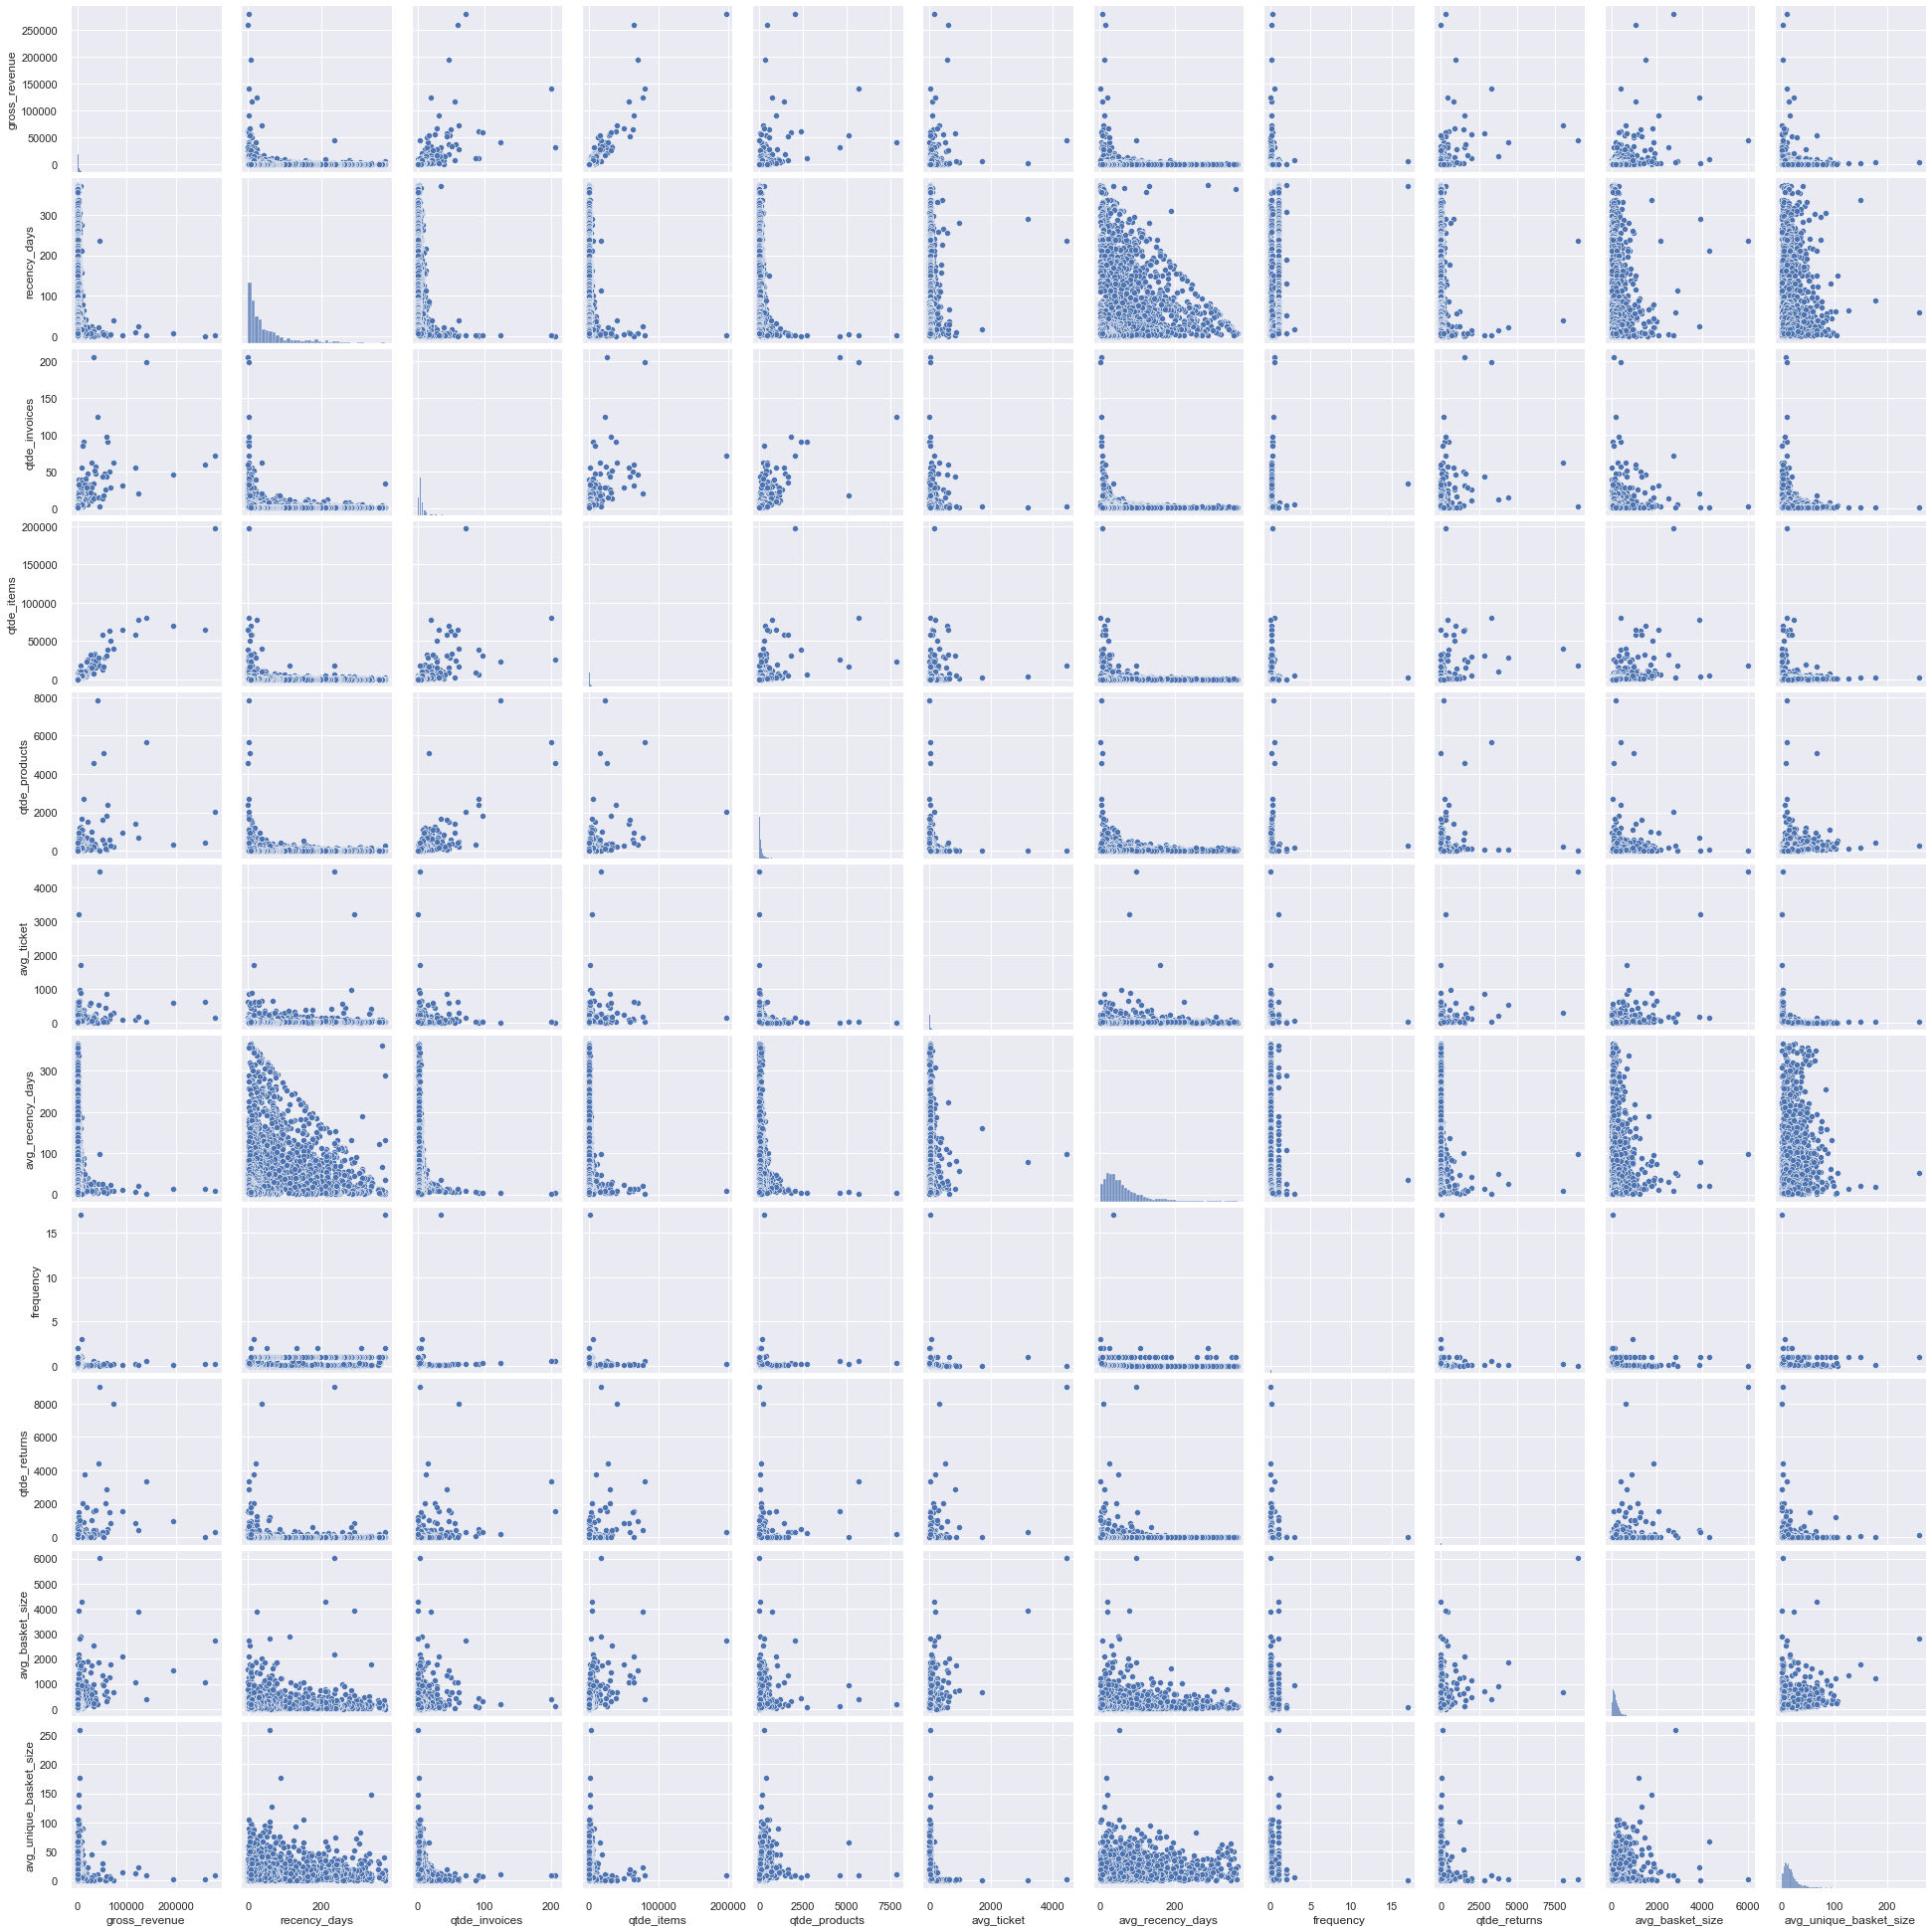

In [65]:
plt.figure( figsize=(25, 12) )
sns.pairplot( df42 )

## 4.3 Estudo do Espaço

In [79]:
# original dataset
#df43 = df4.drop( columns=['customer_id'], axis=1 ).copy()

# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df43 = df4[ cols_selected ].copy() 

In [42]:
df43 = df4.drop( columns=['customer_id'], axis=1 ).copy()

In [80]:
mm = pp.MinMaxScaler()
# 

df43['gross_revenue']           = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days']            = mm.fit_transform( df43[['recency_days']] )
#df43['qtde_invoices']          = mm.fit_transform( df43[['qtde_invoices']])
#df43['qtde_items']             = mm.fit_transform( df43[['qtde_items']])
df43['qtde_products']           = mm.fit_transform( df43[['qtde_products']])
#df43['avg_ticket']             = mm.fit_transform( df43[['avg_ticket']])
#df43['avg_recency_days']       = mm.fit_transform( df43[['avg_recency_days']])
df43['frequency']               = mm.fit_transform( df43[['frequency']])
df43['qtde_returns']            = mm.fit_transform( df43[['qtde_returns']])
#df43['avg_basket_size']        = mm.fit_transform( df43[['avg_basket_size']])
#df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']] )


X = df43.copy()

In [81]:
X.shape

(2968, 6)

### 4.3.1. PCA

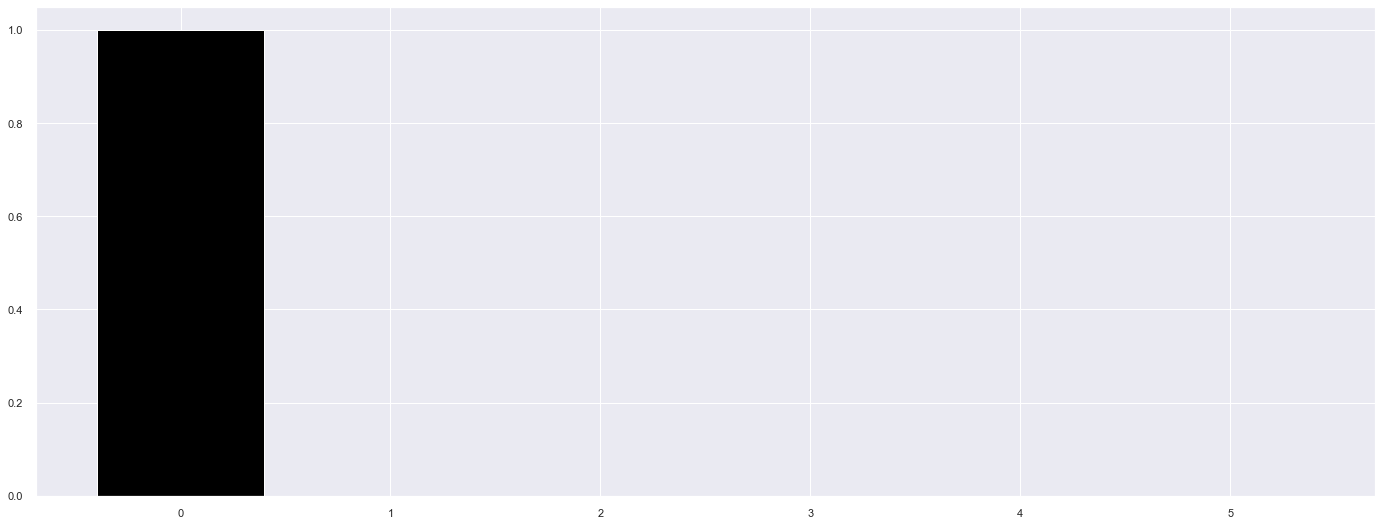

In [82]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

<AxesSubplot:xlabel='0', ylabel='1'>

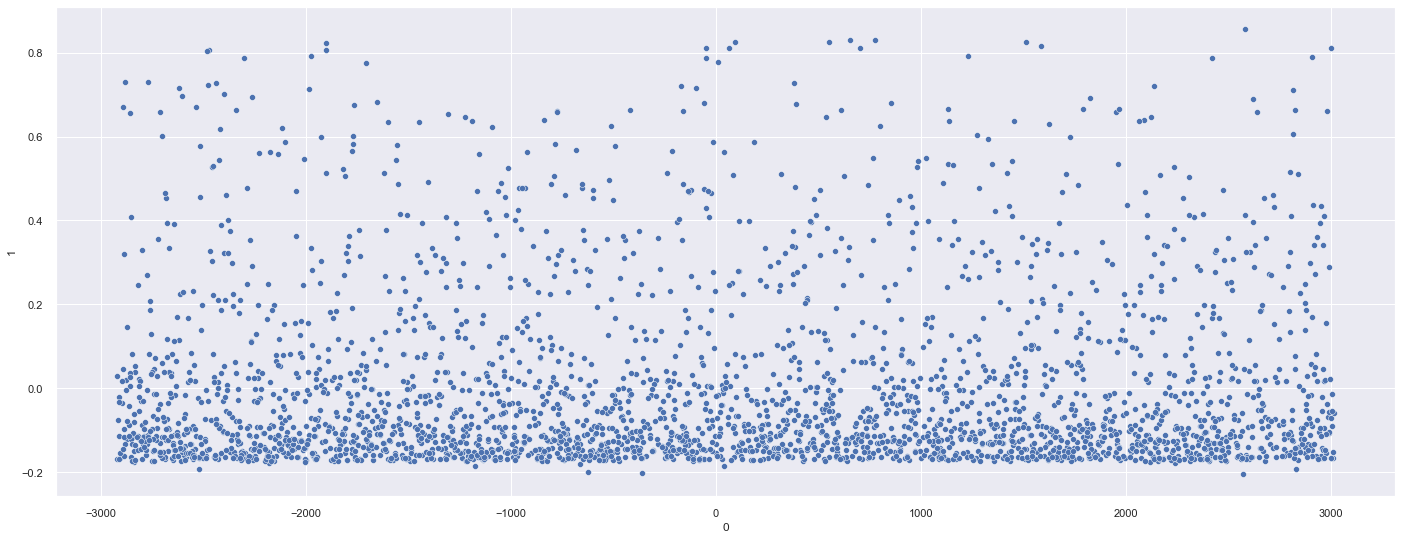

In [83]:
sns.scatterplot( x=0, y=1, data=df_pca )

### 4.3.2. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

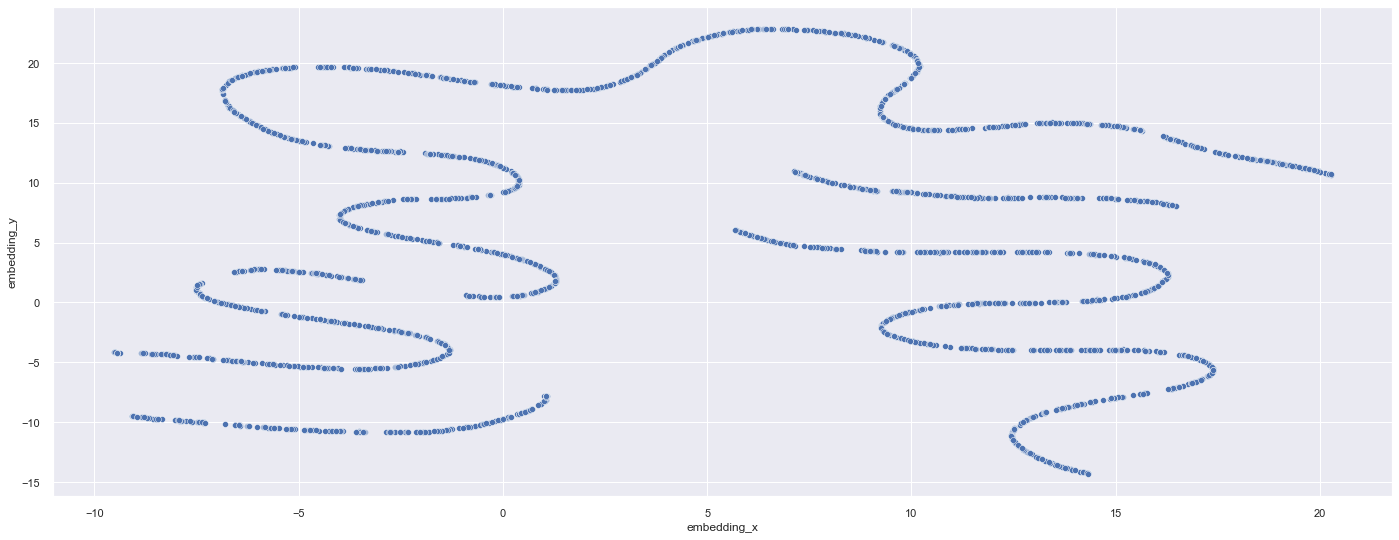

In [84]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

### 4.3.3. t-SNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

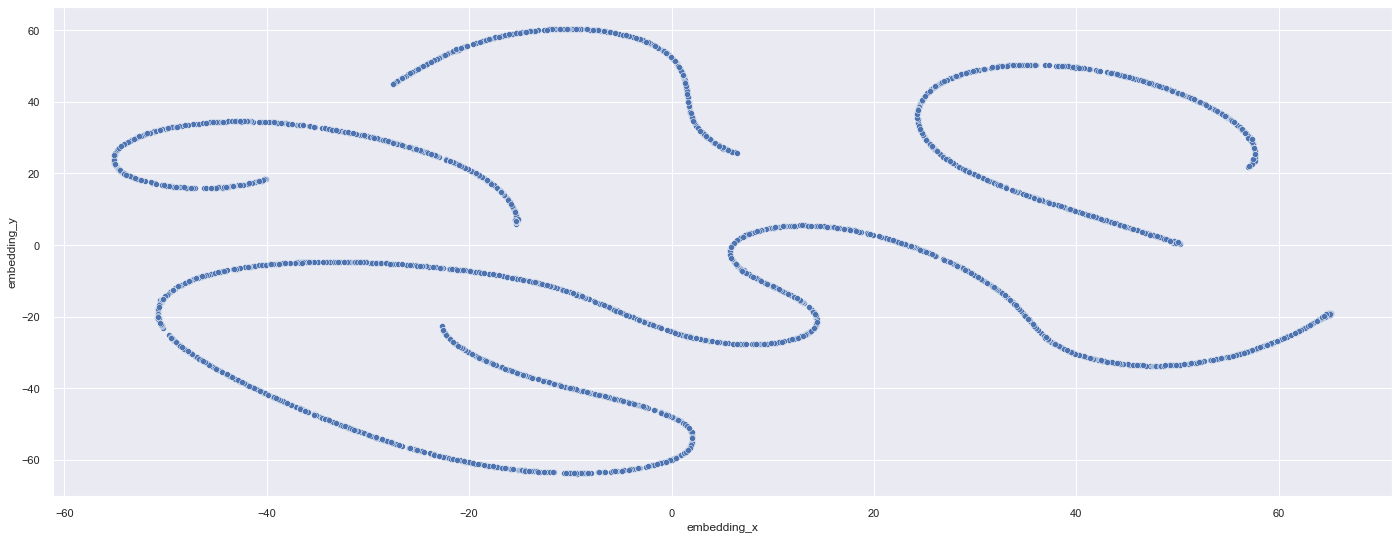

In [85]:
reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

### 4.3.4. Tree-Based Embedding

In [86]:
# training dataset
X = df4.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf 

# dataframe Leaf

RandomForestRegressor(random_state=42)

In [87]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

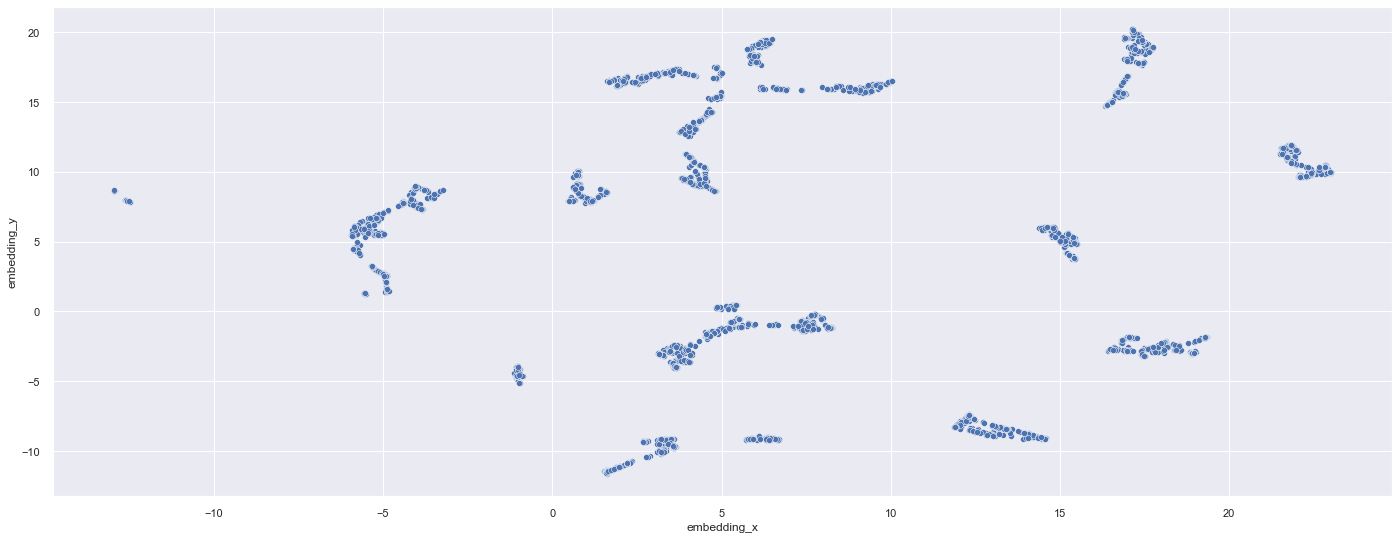

In [88]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree )

# 5.0 Data Preparation

In [89]:
#Padronização/Normalizção ( Standardization ) -> Premissa de que os dados vieram de um distribuição normal
#Rescala      ( Rescale )         -> Não Premissa de que os dados vieram de um distribuição normal

**Regra do Coração**

1. Distribuiçåo Normal e não possui Outlier -> Standard Scaler - Media e desvio padrao
2. Distribuiçåo Normal e possuí Outlier -> Robust Scaler - Quartis
3. Não distribuição normal -> Min Max Scaler

In [90]:
#**Testes de Normalidade**
#QQ Plot  - Quantile Quantile Plot ( Quatile teorica x Quantile real )
#KS Teste - Kolgomorov Smirnoff ( Teste de Hipótese ) Se p-value > 0.5 -> Distribuição Normal, p-value < 0.5 -> Não distribuição Normal
#
#**Detecção Outlier** 
#Box Plot -> Pontos são identificados como Outliers
#IRQ * 2.5 -> Acima desse valor ( Outlier )
#
#Z-Score > 3  -> Outilers
#Z-Score < -3 -> Outliers

In [91]:
#df5 = df4.copy()

df5 = df_tree.copy()

In [92]:
df5.head()

,embedding_x,embedding_y
0,15.416781,3.773419
1,16.840811,-2.090599
2,16.953922,16.712820
3,-4.877395,1.422494
4,6.146158,15.938235


In [93]:
### Standard Scalaer
#ss = pp.StandardScaler()
#rs = pp.RobustScaler()
#mm = pp.MinMaxScaler()
#        
#df5['gross_revenue'] = mm.fit_transform( df5[['gross_revenue']] )
#
#df5['recency_days'] = mm.fit_transform( df5[['recency_days']] )
#
#df5['qtde_invoices'] = mm.fit_transform( df5[['qtde_invoices']] )
#
#df5['qtde_items'] = mm.fit_transform( df5[['qtde_items']] )
#
#df5['qtde_products'] = mm.fit_transform( df5[['qtde_products']] )
#
#df5['avg_ticket'] = mm.fit_transform( df5[['avg_ticket']] )
#
#df5['avg_recency_days'] = mm.fit_transform( df5[['avg_recency_days']] )
#
#df5['frequency'] = mm.fit_transform( df5[['frequency']] )
#
#df5['qtde_returns'] = mm.fit_transform( df5[['qtde_returns']] )
#
#df5['avg_basket_size'] = mm.fit_transform( df5[['avg_basket_size']] )
#
#df5['avg_unique_basket_size'] = mm.fit_transform( df5[['avg_unique_basket_size']] )

# 6.0 Feature Selection

In [94]:
df6 = df_tree.copy()

# 7.0 Hyperparameter Fine-Tunning

In [95]:
#X = df6.drop( columns=['customer_id'] )

In [96]:
X = df_tree.copy()

In [97]:
X.head()

,embedding_x,embedding_y
0,15.416781,3.773419
1,16.840811,-2.090599
2,16.953922,16.712820
3,-4.877395,1.422494
4,6.146158,15.938235


In [98]:
#clusters = [2, 3, 4, 5, 6, 7]

In [99]:
clusters = np.arange( 2, 25, 1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24])

## 7.1 K-Means

In [100]:
from sklearn import metrics as m

In [101]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

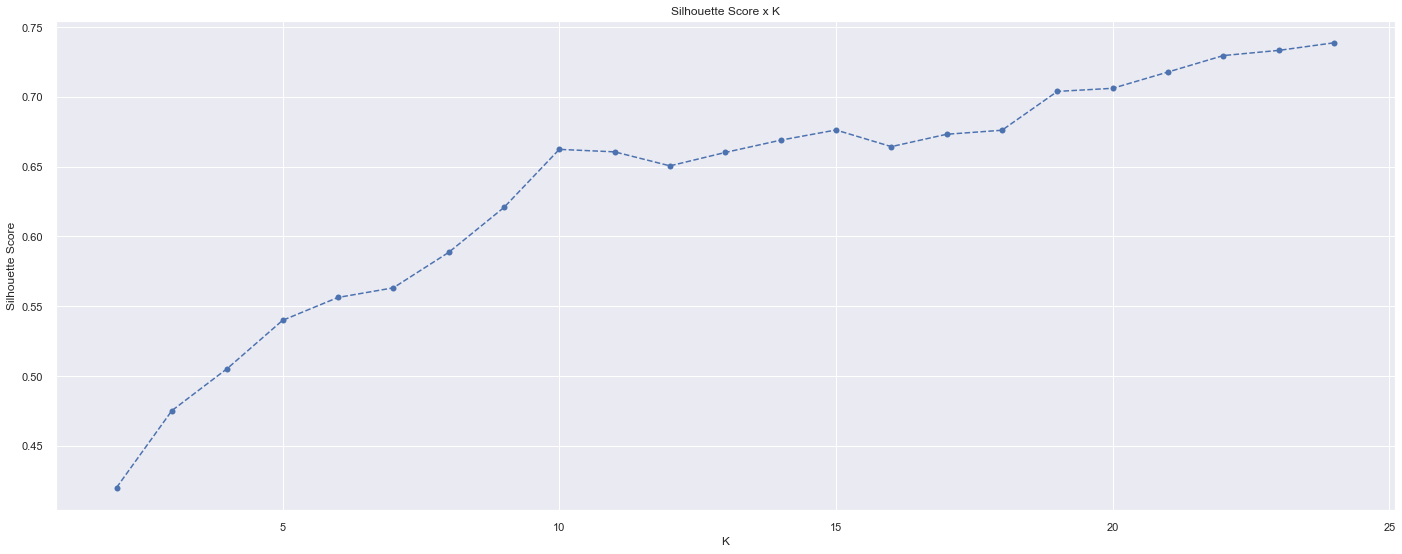

In [102]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.2 GMM

In [103]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

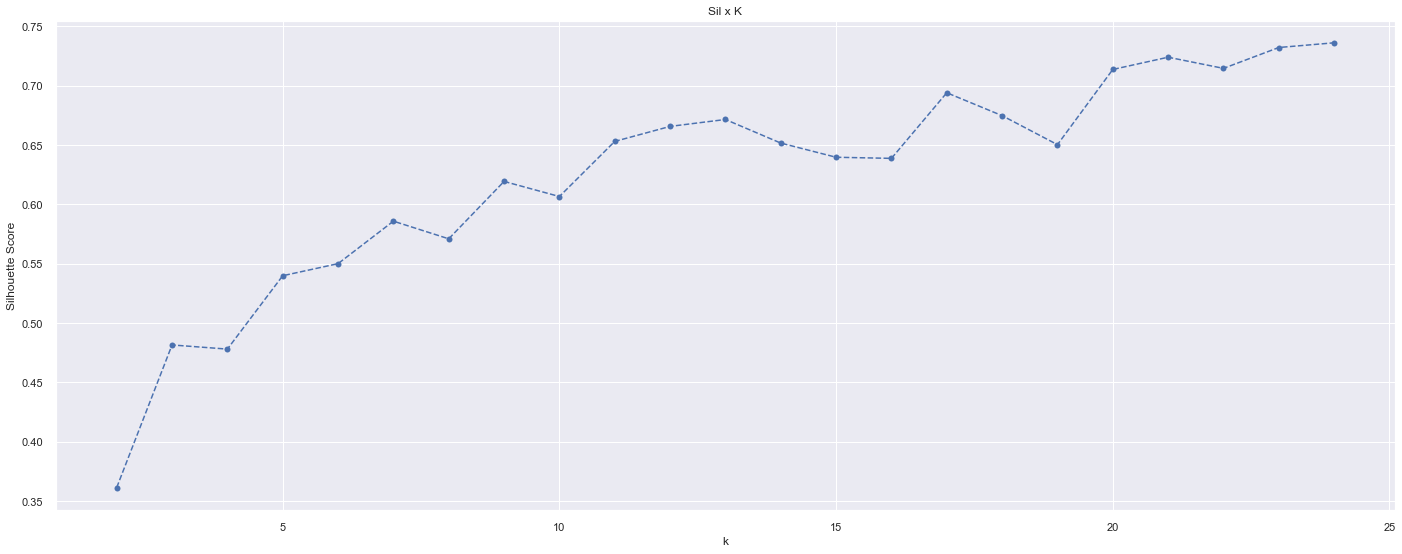

In [104]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## 7.3 Hierarchical Clustering

In [105]:
from scipy.cluster import hierarchy as hc

In [106]:
# model definition and training
hc_model = hc.linkage( X, 'ward' )

[]

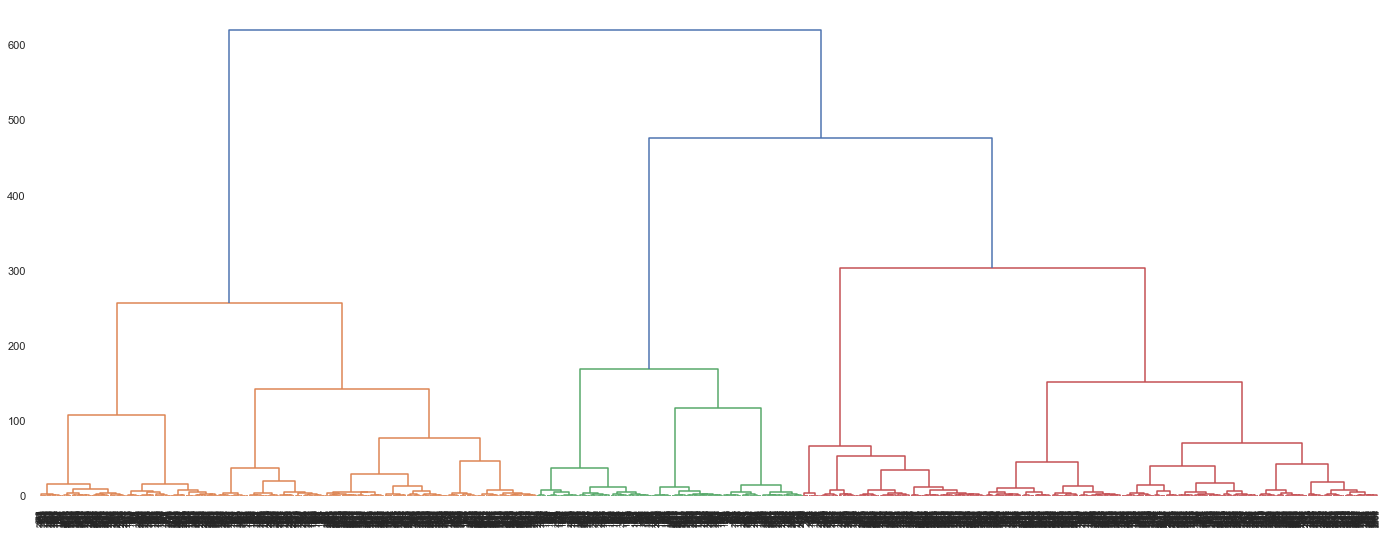

In [107]:
hc.dendrogram( 
    hc_model, 
    leaf_rotation=90,
    leaf_font_size=8
)

plt.plot()

## 7.3.1 Hierarchical Clustering Silhouette Score

In [108]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

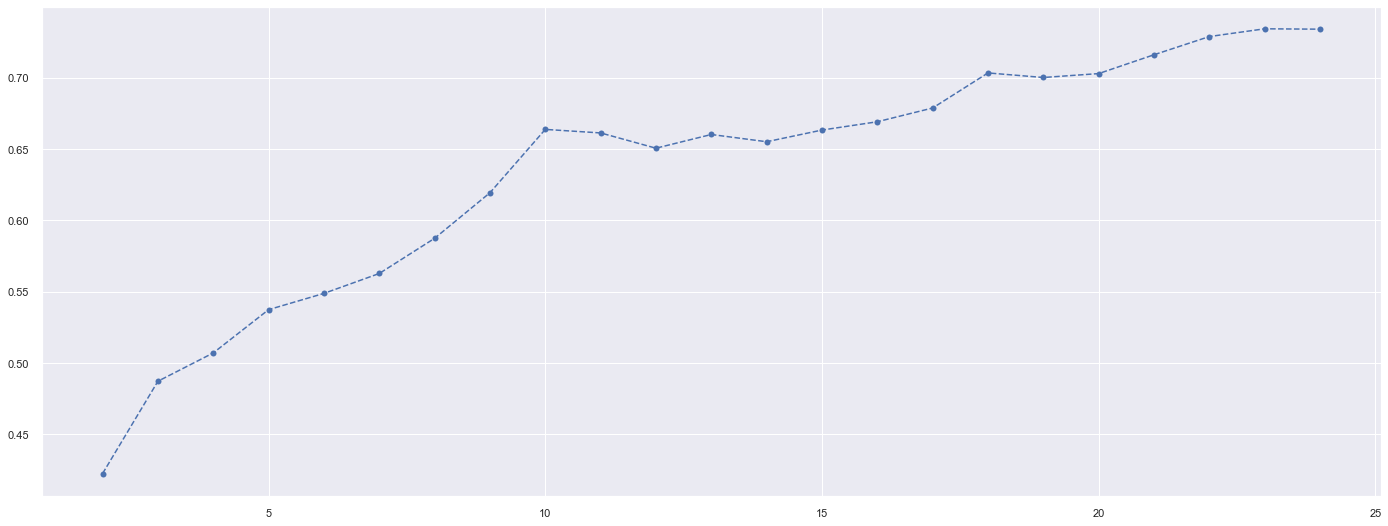

In [109]:
 plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

## 7.4 DBScan

In [110]:
eps=2.00
min_samples=20 

# model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# mode training & predict 
labels = dbscan_model.fit_predict( X )

sil = m.silhouette_score( X, labels, metric='euclidean' )
print( 'Silhouette Score: {}'.format( sil ) )
print( 'Number of Clusters: {}'.format( len( unique( labels ) ) ) )
print( unique( labels ) )

Silhouette Score: 0.6287170052528381
Number of Clusters: 13
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [111]:
 from sklearn.neighbors import NearestNeighbors

In [112]:
neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

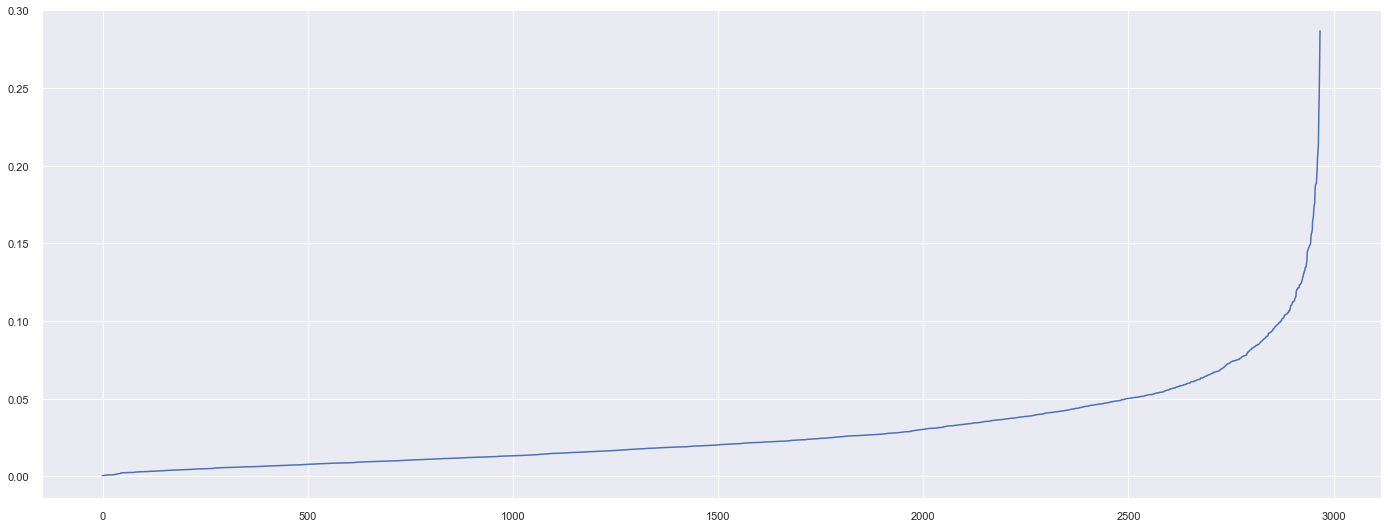

In [113]:
distances = np.sort( distances, axis=0 )
distances = distances[:,1]
plt.plot( distances )

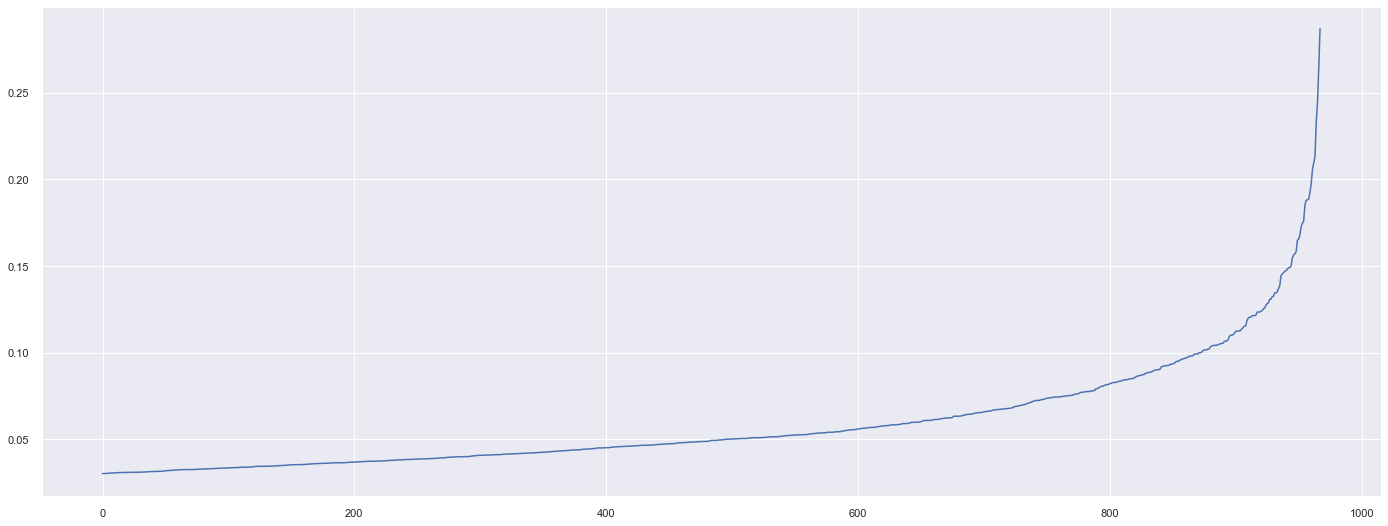

In [114]:
plt.plot( distances[2000:] )

In [115]:
 dbscan_list = [ 0.622034, 0.000000, 0.000000, 0.000000]

## 7.5 Results

In [116]:
# Model Name | k=2 | k=3 | k=4 | k=5 | ...
#  Kmeans      SS    SS    SS    SS
#  GMM         SS    SS    SS    SS
#  HC         SS     SS    SS    SS
#  DBSCAN     SS    SS    SS    SS

df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list}
     #'DBSCAN': dbscan_list}
).T

df_results.columns = clusters

In [85]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.420103,0.475215,0.505321,0.539842,0.556223,0.576902,0.588488,0.615315,0.662277,0.660502,0.650474,0.660074,0.642222,0.661226,0.657244,0.663126,0.668503,0.703169,0.705981,0.718333,0.729459,0.733159,0.738595
GMM,0.424987,0.405837,0.452790,0.539842,0.554307,0.571577,0.578968,0.618947,0.662625,0.642207,0.650110,0.649047,0.664451,0.655082,0.673361,0.655283,0.676961,0.689071,0.724348,0.687668,0.726576,0.672622,0.716365
HC,0.422482,0.487172,0.507003,0.537331,0.548722,0.562671,0.587317,0.619241,0.663644,0.661169,0.650474,0.660074,0.655000,0.663182,0.669001,0.678641,0.703206,0.700013,0.702754,0.715948,0.728702,0.734138,0.733870


## 7.1 Silhoute Analysis

 For K = 2. Silhouette Score: 0.42248231172561646
 For K = 3. Silhouette Score: 0.4871721565723419
 For K = 4. Silhouette Score: 0.5070030093193054
 For K = 5. Silhouette Score: 0.5373305082321167
 For K = 6. Silhouette Score: 0.548721969127655
 For K = 7. Silhouette Score: 0.5626710057258606
 For K = 8. Silhouette Score: 0.5873167514801025
 For K = 9. Silhouette Score: 0.6192408800125122
 For K = 10. Silhouette Score: 0.6636439561843872
 For K = 11. Silhouette Score: 0.6611685752868652
 For K = 12. Silhouette Score: 0.6504743099212646
 For K = 13. Silhouette Score: 0.66007399559021
 For K = 14. Silhouette Score: 0.6550004482269287
 For K = 15. Silhouette Score: 0.6631820201873779
 For K = 16. Silhouette Score: 0.6690008640289307
 For K = 17. Silhouette Score: 0.6786412000656128
 For K = 18. Silhouette Score: 0.703205943107605
 For K = 19. Silhouette Score: 0.7000132203102112
 For K = 20. Silhouette Score: 0.7027539610862732
 For K = 21. Silhouette Score: 0.7159478068351746
 For K = 22

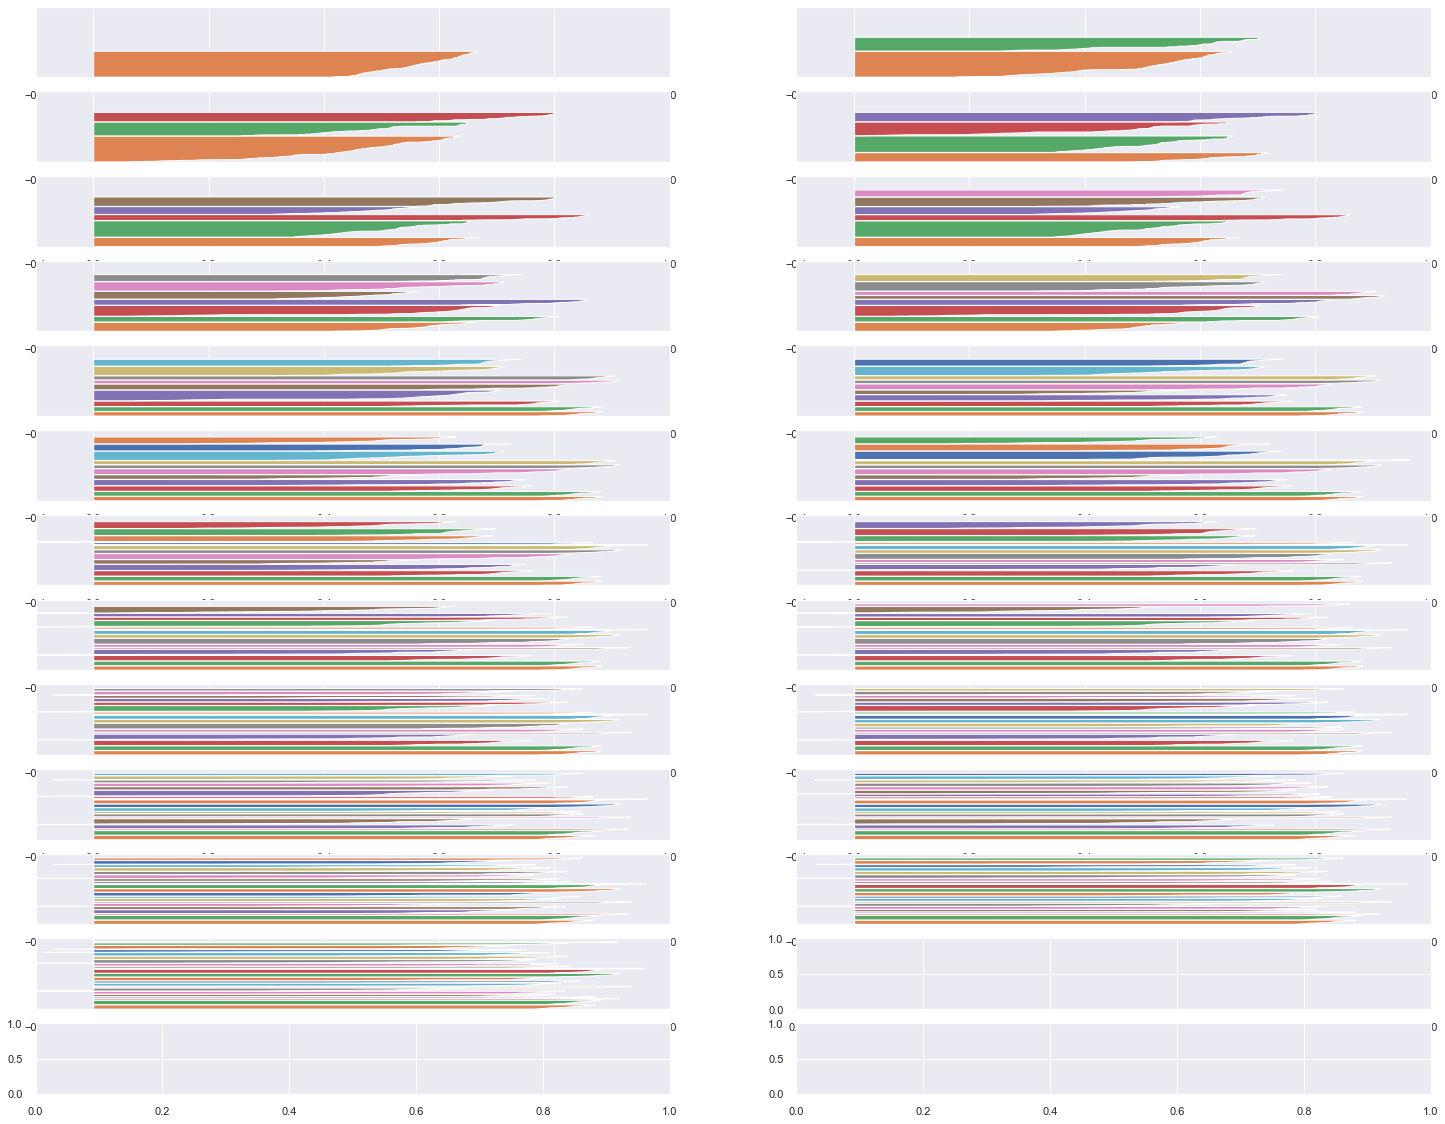

In [117]:
fig, ax = plt.subplots( 13, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
    
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = m.silhouette_score( X, labels, metric='euclidean' )
    print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

    samples_silhouette_values = m.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

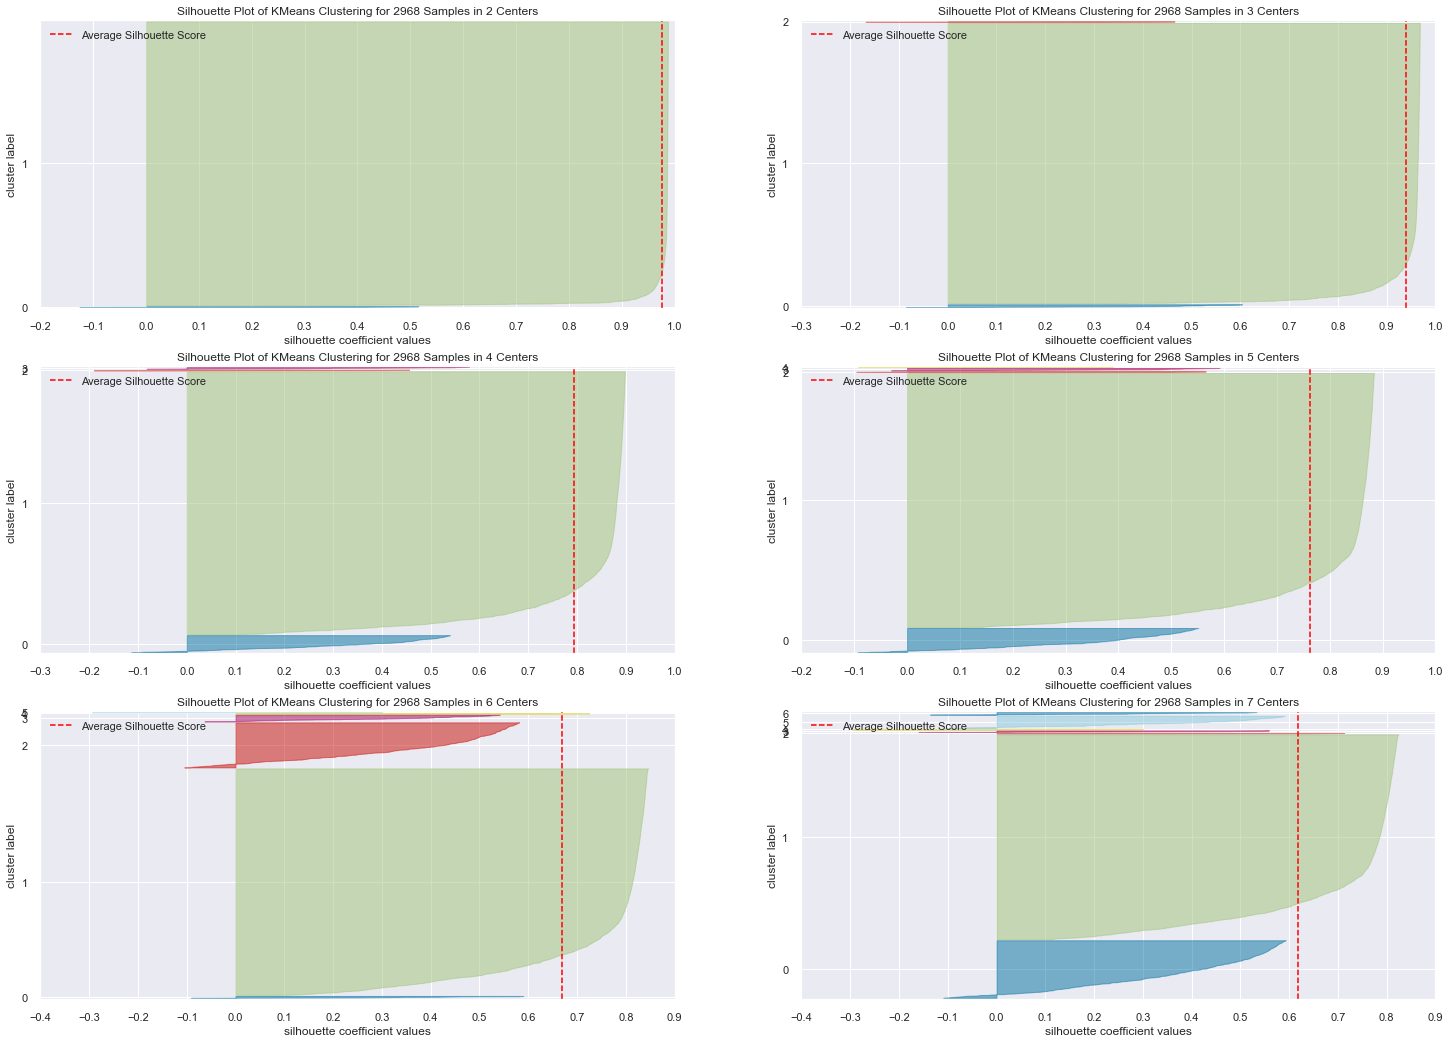

In [66]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

# 8.0 Model Training

## 8.1 K-Means

In [136]:
# model definition
k = 9
#kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300 )
#
## model training
#kmeans.fit( X )
#
## clustering
#labels = kmeans.labels_

In [137]:
## model definition
kmeans = mx.GaussianMixture( n_components=k )

# model training
kmeans.fit( X )

# model predict
labels = kmeans.predict( X )

## 8.2 Cluster Validation

In [138]:
## WSS ( Within-cluster sum of square)
#print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

SS value: 0.6156403422355652


# 9.0 Cluster Analysis

In [139]:
 X.head()

,embedding_x,embedding_y
0,15.416781,3.773419
1,16.840811,-2.090599
2,16.953922,16.712820
3,-4.877395,1.422494
4,6.146158,15.938235


In [140]:
df9 = X.copy()
df9['cluster'] = labels

In [141]:
df9.head()

,embedding_x,embedding_y,cluster
0,15.416781,3.773419,1
1,16.840811,-2.090599,1
2,16.953922,16.712820,6
3,-4.877395,1.422494,0
4,6.146158,15.938235,2


## 9.1 Visualization Inspection

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

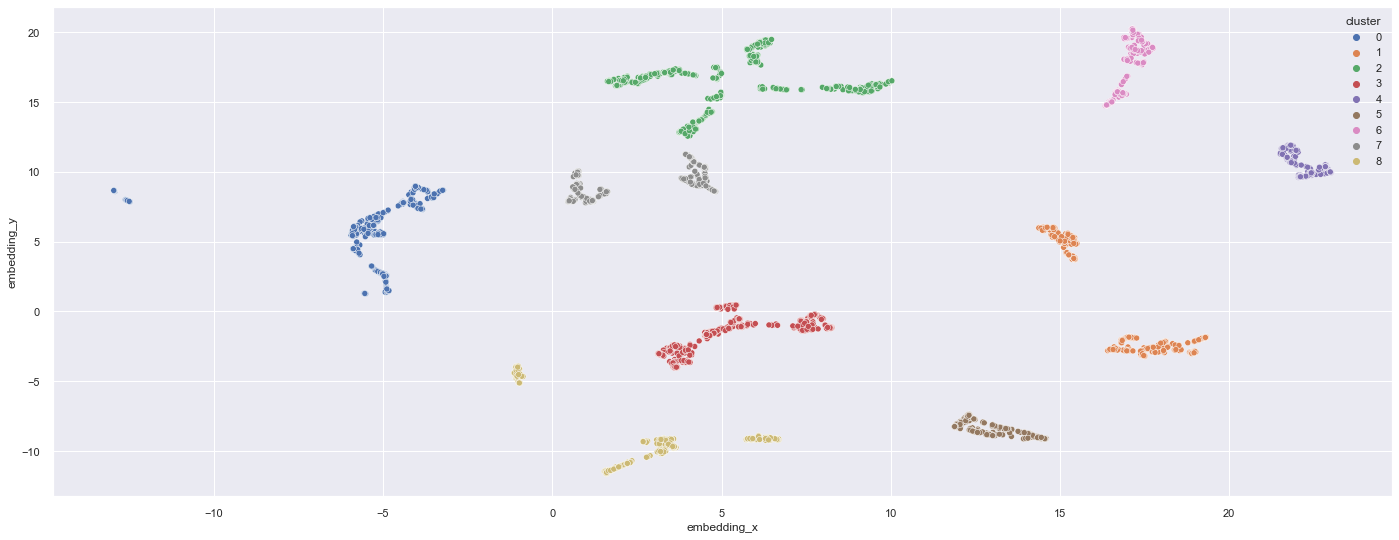

In [142]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

## 9.2 2D Plot

In [105]:
#df9 = df4.copy()
#df9['cluster'] = labels

In [114]:
df_viz = df9
#sns.pairplot( df_viz, hue='cluster' )

## 9.3 UMAP

In [76]:
#reducer = umap.UMAP( n_neighbors=90, random_state=42 )
#embedding = reducer.fit_transform( X )
#
## embedding
#df_viz['embedding_x'] = embedding[:, 0]
#df_viz['embedding_y'] = embedding[:, 1]
#
## plot UMAP
#sns.scatterplot( x='embedding_x', y='embedding_y', 
#                 hue='cluster', 
#                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
#                 data=df_viz )

## 9.5 Cluster Profile

In [143]:
df92 = df4[ cols_selected ].copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,1
1,13047,3232.59,56.0,171.0,0.028302,35.0,1
2,12583,6705.38,2.0,232.0,0.040323,50.0,6
3,13748,948.25,95.0,28.0,0.017921,0.0,0
4,15100,876.00,333.0,3.0,0.073171,22.0,2


In [145]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_qtde_products = df92[['qtde_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Returns
df_qtde_returns = df92[['qtde_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster' )

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,0,405,13.645553,6717.082543,70.639506,158.340741,0.092403,117.019753
1,1,364,12.264151,2589.838654,40.629121,161.373626,0.085713,22.862637
2,2,568,19.137466,360.831937,113.825704,24.966549,0.257344,5.517606
3,3,399,13.443396,1066.811328,65.137845,72.776942,0.073493,12.110276
4,4,176,5.929919,3900.387727,27.022727,229.409091,0.036884,36.562500
5,5,194,6.536388,1901.593711,40.412371,111.716495,0.039108,28.036082
6,6,255,8.591644,7760.927451,22.698039,336.725490,0.076508,81.882353
7,7,301,10.141509,580.879668,85.069767,48.039867,0.159812,5.664452
8,8,306,10.309973,1605.473856,41.957516,117.333333,0.039364,17.676471


Cluster 01
- Número de customers: 255 (8,59% do customers )
- Recência em média: 22,69 dias
- Compras em média: 336 produtos
- Receita em média: $7760 dólares

Cluster 02
- Número de customers: 31 (0.71 do customers )
- Recência em média: 14 dias
- Compras em média: 53 compras
- Receita em média: $40.543,52 dólares

Cluster 03
- Número de customers: 4.335 (99% do customers )
- Recência em média: 92 dias
- Compras em média: 5 compras
- Receita em média: $1.372,57 dólares

# 10.0 Model to Production